In [1]:
"""
    IMPORTING LIBS
"""
import dgl

import numpy as np
import os
import socket
import time
import random
import glob
import argparse, json
import pandas as pd

from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from tensorboardX import SummaryWriter
from tqdm import tqdm

from sklearn.metrics import balanced_accuracy_score, confusion_matrix

import sklearn
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import math

# custom function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [2]:
# some_file.py
import sys
#change location to GNN_RIVM folder
sys.path.insert(1, '/home/jeroen/Documents/Toxic/GNN_rivm/benchmark')

from nets.TUs_graph_classification.load_net import gnn_model # import GNNs
from data.data import LoadData # import dataset
from train.train_TUs_graph_classification import train_epoch, evaluate_network, evaluate_network2 # import train functions

drop_last = False
device = torch.device("cpu")

In [3]:
def create_net_params(file_name):
    f = open(file_name, "r")
    n_params = (f.readlines()[5].split(" "))
    net_params = dict()
    pbt_params_int = ['in_dim', 'hidden_dim', 'n_classes', 'L', 'n_mlp_GIN']
    int_idx = [29,3,31,1,9]
    pbt_params_str = ['learn_eps_GIN', 'neighbor_aggr_GIN', 'readout', 'graph_norm', 'batch_norm', 'residual']
    str_idx = [11,13,7,19,21,5]
    
    for idx1, par in enumerate(pbt_params_int):
        net_params[par] = int(n_params[int_idx[idx1]].split(',')[0])
    net_params['in_feat_dropout'] = float(n_params[15].split(',')[0])
    net_params['dropout'] = float(n_params[17].split(',')[0])
    for idx2, par in enumerate(pbt_params_str):
        net_params[par] =  n_params[str_idx[idx2]].split(',')[0].strip("'")
    return net_params 

In [4]:
folder = "GINPBTn/"
model_str = "GIN"

gin1_file = "GIN_PBT_Repn1_GPU0_08h22m01s_on_Jul_01_2020"
gin2_file = "GIN_PBT_Repn2_GPU0_08h22m05s_on_Jul_01_2020"
gin3_file = "GIN_PBT_Repn3_GPU0_08h22m01s_on_Jul_01_2020"
gin4_file = "GIN_PBT_Repn4_GPU0_08h22m13s_on_Jul_01_2020"

In [5]:
gin1_np = create_net_params(folder+"config_"+gin1_file+".txt")
gin2_np = create_net_params(folder+"config_"+gin2_file+".txt")
gin3_np = create_net_params(folder+"config_"+gin3_file+".txt")
gin4_np = create_net_params(folder+"config_"+gin4_file+".txt")

In [6]:
print(gin3_np)
gin3_np['hidden_dim'] = 128

{'in_dim': 19, 'hidden_dim': 96, 'n_classes': 2, 'L': 2, 'n_mlp_GIN': 2, 'in_feat_dropout': 0.5, 'dropout': 0.5, 'learn_eps_GIN': 'True', 'neighbor_aggr_GIN': 'sum', 'readout': 'sum', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}


In [7]:
gin3_np['L'] = 4
gin3_np['hidden_dim'] = 128
print(gin3_np)
# gin3_np['hidden_dim'] = 192
# gin4_np['L'] = 8
# print(gin3_np)
# print(gin4_np)

{'in_dim': 19, 'hidden_dim': 128, 'n_classes': 2, 'L': 4, 'n_mlp_GIN': 2, 'in_feat_dropout': 0.5, 'dropout': 0.5, 'learn_eps_GIN': 'True', 'neighbor_aggr_GIN': 'sum', 'readout': 'sum', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}


In [8]:
print(gin1_np)
print(gin2_np)
print(gin3_np)
print(gin4_np)

{'in_dim': 15, 'hidden_dim': 128, 'n_classes': 2, 'L': 6, 'n_mlp_GIN': 2, 'in_feat_dropout': 0.5, 'dropout': 0.5, 'learn_eps_GIN': 'True', 'neighbor_aggr_GIN': 'sum', 'readout': 'sum', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}
{'in_dim': 23, 'hidden_dim': 128, 'n_classes': 2, 'L': 6, 'n_mlp_GIN': 2, 'in_feat_dropout': 0.5, 'dropout': 0.5, 'learn_eps_GIN': 'True', 'neighbor_aggr_GIN': 'sum', 'readout': 'sum', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}
{'in_dim': 19, 'hidden_dim': 128, 'n_classes': 2, 'L': 4, 'n_mlp_GIN': 2, 'in_feat_dropout': 0.5, 'dropout': 0.5, 'learn_eps_GIN': 'True', 'neighbor_aggr_GIN': 'sum', 'readout': 'sum', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}
{'in_dim': 86, 'hidden_dim': 96, 'n_classes': 2, 'L': 4, 'n_mlp_GIN': 2, 'in_feat_dropout': 0.5, 'dropout': 0.5, 'learn_eps_GIN': 'True', 'neighbor_aggr_GIN': 'sum', 'readout': 'sum', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}


In [8]:
dataset1 = LoadData("PBT_Repn1")
dataset2 = LoadData("PBT_Repn2")
dataset3 = LoadData("PBT_Repn3")
dataset4 = LoadData("PBT_Repn4")

971
preparing 971 graphs for the ALL set...
[!] Dataset:  PBT_Repn1
Time taken: 9.9788s
971
preparing 971 graphs for the ALL set...
[!] Dataset:  PBT_Repn2
Time taken: 20.1899s
971
preparing 971 graphs for the ALL set...
[!] Dataset:  PBT_Repn3
Time taken: 17.5312s
971
preparing 971 graphs for the ALL set...
[!] Dataset:  PBT_Repn4
Time taken: 10.8901s


In [9]:
drop_last = False
device = torch.device("cpu")

In [10]:
def test_model(net_params, model_name, dataset, model_str):
    accs = []
    for i in range(10):
        model = gnn_model(model_str, net_params)
        onlyfiles = [f for f in listdir(model_name + str(i)) if isfile(join(model_name + str(i), f))]
        model.load_state_dict(torch.load(model_name + str(i) +"/"+ onlyfiles[-1]))
        trainset, valset, testset = dataset.train[i], dataset.val[i], dataset.test[i]
#         train_loader = DataLoader(trainset, batch_size=20, shuffle=True, drop_last=drop_last, collate_fn=dataset.collate)
#         val_loader = DataLoader(valset, batch_size=20, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        test_loader = DataLoader(testset, batch_size=1, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        epoch_val_loss, epoch_val_acc = evaluate_network(model, device, test_loader, 999)
        accs.append(epoch_val_acc)
    print(np.mean(accs),np.std(accs))
#     print(accs)

In [11]:
def test_model2(net_params, model_name, dataset, model_str):
    accs = []
    labs = []
    for i in range(10):
        model = gnn_model(model_str, net_params)
        onlyfiles = [f for f in listdir(model_name + str(i)) if isfile(join(model_name + str(i), f))]
        model.load_state_dict(torch.load(model_name + str(i) +"/"+ onlyfiles[-1]))
        trainset, valset, testset = dataset.train[i], dataset.val[i], dataset.test[i]
        test_loader = DataLoader(testset, batch_size=1, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        epoch_val_loss, labels, score = evaluate_network2(model, device, test_loader, 999)
        accs.extend(score)
        labs.extend(labels)
    return accs, labs

In [12]:
def test_model3(net_params, model_name, dataset, model_str):
    accs = []
    labs = []
    for i in range(10):
        model = gnn_model(model_str, net_params)
        onlyfiles = [f for f in listdir(model_name + str(i)) if isfile(join(model_name + str(i), f))]
        model.load_state_dict(torch.load(model_name + str(i) +"/"+ onlyfiles[-1]))
        trainset, valset, testset = dataset.train[i], dataset.val[i], dataset.test[i]
        test_loader = DataLoader(testset, batch_size=1, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        epoch_val_loss, labels, score = evaluate_network2(model, device, test_loader, 999)
        accs.append(score)
        labs.append(labels)
    return accs, labs

In [13]:
test_model(gin1_np, folder+gin1_file+"/RUN_", dataset1, model_str)
test_model(gin2_np, folder+gin2_file+"/RUN_", dataset2, model_str)
test_model(gin3_np, folder+gin3_file+"/RUN_", dataset3, model_str)
test_model(gin4_np, folder+gin4_file+"/RUN_", dataset4, model_str)

0.902177900758612 0.04266203036368322
0.9239968080255359 0.06497807219322628
0.9521484682667992 0.032889738854116106
0.9184892011772996 0.0646180571219725


In [14]:
accs1, labels1 = test_model2(gin1_np, folder+gin1_file+"/RUN_", dataset1, model_str)
accs2, labels2 = test_model2(gin2_np, folder+gin2_file+"/RUN_", dataset2, model_str)
accs3, labels3 = test_model2(gin3_np, folder+gin3_file+"/RUN_", dataset3, model_str)
accs4, labels4 = test_model2(gin4_np, folder+gin4_file+"/RUN_", dataset4, model_str)

In [15]:
acclist1, lablist1 = test_model3(gin1_np, folder+gin1_file+"/RUN_", dataset1, model_str)
acclist2, lablist2 = test_model3(gin2_np, folder+gin2_file+"/RUN_", dataset2, model_str)
acclist3, lablist3 = test_model3(gin3_np, folder+gin3_file+"/RUN_", dataset3, model_str)
acclist4, lablist4 = test_model3(gin4_np, folder+gin4_file+"/RUN_", dataset4, model_str)

In [28]:
print(acclist3)

[[[-4.721020698547363, -3.720705270767212], [-8.45724105834961, -4.8628129959106445], [-10.08454704284668, -5.315932273864746], [-8.893217086791992, -5.681243419647217], [2.534881114959717, 8.739649772644043], [-14.00106430053711, -4.666454315185547], [-7.721632957458496, -4.83927583694458], [4.642420291900635, 5.456589698791504], [-10.731415748596191, -4.415062427520752], [-4.481880187988281, -3.583983898162842], [-8.89305305480957, -3.251411199569702], [-4.419035911560059, 5.804592132568359], [1.1996421813964844, 0.25223588943481445], [-1.7749829292297363, -4.09908390045166], [8.817302703857422, -7.345279693603516], [0.3375486135482788, 0.0569157600402832], [-7.868896961212158, -15.340539932250977], [0.08597353100776672, -1.972019910812378], [35.854156494140625, 8.00444221496582], [15.371685981750488, -1.5615471601486206], [-8.78857421875, -12.867630004882812], [3.1830995082855225, 3.081329345703125], [-3.0720152854919434, -5.292000770568848], [-6.809133529663086, -8.821115493774414]

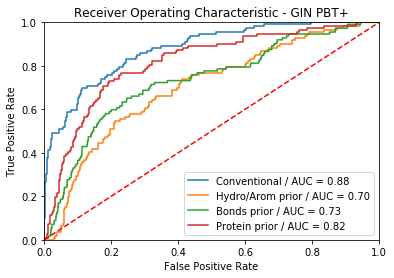

In [16]:
accuracies = [accs1, accs2, accs3, accs4]
acclists = [acclist1, acclist2, acclist3, acclist4]

labels = ["Conventional", "Hydro/Arom prior", "Bonds prior", "Protein prior"]
for idx, ac in enumerate(accuracies):
    fpr, tpr, threshold = metrics.roc_curve(labels1, sigmoid(np.array(ac))[:,1])
    roc_auc = metrics.roc_auc_score(labels1, sigmoid(np.array(ac))[:,1])
    plt.title('Receiver Operating Characteristic - GIN PBT+')
    plt.plot(fpr, tpr, label = labels[idx]+' / AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [17]:
for acc in acclists:
    rec = []
    pre = []
    for idx, acc_fold in enumerate(acc):
        rec.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_fold, axis=1)))
        pre.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_fold, axis=1)))
#     print(rec)
    print("%.4f %.4f" % (np.mean(pre), np.mean(rec)))
#     print("%.4f" % np.mean(pre), np.std(pre))

0.7291 0.8568
0.8827 0.8667
0.7593 0.9462
0.7760 0.8742


In [18]:
from collections import Counter
idx_wrong = []
idx_wrong2 = []
for acc in accuracies:
    idx_wrong.append(([i for i,x in enumerate(labels1 == np.argmax(acc,axis=1)) if x == False]))
    idx_wrong2.extend(([i for i,x in enumerate(labels1 == np.argmax(acc,axis=1)) if x == False]))
    
idx_allwrong  = sorted(list(set(idx_wrong[0])&set(idx_wrong[1])&set(idx_wrong[2])&set(idx_wrong[3])))
print(Counter(Counter(idx_wrong2).values()))
print(len(Counter(idx_wrong2)))
print(Counter(idx_wrong2))
print(idx_allwrong)

Counter({1: 51, 2: 25, 4: 13, 3: 9})
98
Counter({105: 4, 193: 4, 195: 4, 203: 4, 218: 4, 391: 4, 398: 4, 495: 4, 679: 4, 688: 4, 694: 4, 948: 4, 969: 4, 150: 3, 201: 3, 205: 3, 306: 3, 496: 3, 607: 3, 967: 3, 135: 3, 827: 3, 0: 2, 9: 2, 129: 2, 144: 2, 190: 2, 274: 2, 319: 2, 489: 2, 579: 2, 580: 2, 584: 2, 590: 2, 704: 2, 721: 2, 830: 2, 897: 2, 916: 2, 956: 2, 7: 2, 196: 2, 131: 2, 289: 2, 322: 2, 453: 2, 601: 2, 120: 1, 156: 1, 279: 1, 283: 1, 350: 1, 355: 1, 484: 1, 594: 1, 701: 1, 708: 1, 712: 1, 722: 1, 766: 1, 769: 1, 771: 1, 773: 1, 777: 1, 784: 1, 818: 1, 891: 1, 892: 1, 894: 1, 901: 1, 92: 1, 119: 1, 206: 1, 63: 1, 227: 1, 253: 1, 264: 1, 292: 1, 536: 1, 560: 1, 563: 1, 565: 1, 677: 1, 845: 1, 923: 1, 147: 1, 164: 1, 169: 1, 226: 1, 248: 1, 291: 1, 486: 1, 488: 1, 829: 1, 858: 1, 869: 1, 870: 1, 921: 1})
[105, 193, 195, 203, 218, 391, 398, 495, 679, 688, 694, 948, 969]


In [19]:
thrice = [150,201,205,306,496,607,967,135,827]

In [20]:
check_list = thrice
print(np.array(labels1)[check_list])
print(np.argmax(sigmoid(np.array(accs1)),axis=1)[check_list])
print(np.argmax(sigmoid(np.array(accs2)),axis=1)[check_list])
print(np.argmax(sigmoid(np.array(accs3)),axis=1)[check_list])
print(np.argmax(sigmoid(np.array(accs4)),axis=1)[check_list])

[0 1 1 0 1 0 0 0 0]
[1 0 0 1 0 1 1 0 0]
[1 0 0 0 0 0 1 1 1]
[1 1 1 1 1 1 1 1 1]
[0 0 0 1 0 1 0 1 1]


In [16]:
accuracies = [accs1, accs3, accs2, accs4]
for acc in accuracies:
    print(confusion_matrix(labels1, np.argmax(acc, axis=1)))

[[814  45]
 [ 16  96]]
[[823  36]
 [  6 106]]
[[843  16]
 [ 15  97]]
[[827  32]
 [ 14  98]]


In [22]:
accs = []
for idx1, acc1 in enumerate(acclists):
    acc_temp = []
    for idx, acc_fold in enumerate(acc1):
        acc_samen = (sigmoid(np.array(acclists[0][idx]))+sigmoid(np.array(acclists[idx1][idx])))/2
        acc_temp.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    accs.append([idx1, np.mean(acc_temp), np.std(acc_temp)])
        
df = pd.DataFrame(accs)
for a in list(df.values):
    print("%.2f+/-%.2f" % (100*a[1],100*a[2]))
rep123=[]
rep124=[]
rep1234=[]
for idx in range(10):
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx])))/3
    rep123.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx])))/3
    rep124.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx]))+sigmoid(np.array(acclist4[idx])))/4
    rep1234.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
print("%.2f+/-%.2f" % (100*np.mean(rep123), 100*np.std(rep123)))
print("%.2f+/-%.2f" % (100*np.mean(rep124), 100*np.std(rep124)))
print("%.2f+/-%.2f" % (100*np.mean(rep1234), 100*np.std(rep1234)))

90.22+/-4.27
91.20+/-5.41
91.02+/-5.34
91.72+/-5.63
91.32+/-5.71
91.32+/-5.71
91.90+/-5.61


In [26]:
print(accslist1)

NameError: name 'accslist1' is not defined

In [25]:
acclists = [acclist1, acclist3, acclist2, acclist4]
accs = []
for idx1, acc1 in enumerate(acclists):
    acc_temp = []
    rec = []
    pre = []
    for idx, acc_fold in enumerate(acc1):
        acc_samen = (sigmoid(np.array(acclists[0][idx]))+sigmoid(np.array(acclists[idx1][idx])))/2
        rec.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
        pre.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    accs.append([idx1, np.mean(pre), np.mean(rec)])
        
df = pd.DataFrame(accs)
for a in list(df.values):
    print("%.1f %.1f" % (100*a[1],100*a[2]))
rep123r=[]
rep124r=[]
rep1234r=[]
rep123p=[]
rep124p=[]
rep1234p=[]
for idx in range(10):
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist3[idx]))+sigmoid(np.array(acclist2[idx])))/3
    rep123r.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    rep123p.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist3[idx]))+sigmoid(np.array(acclist4[idx])))/3
    rep124r.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    rep124p.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx]))+sigmoid(np.array(acclist4[idx])))/4
    rep1234r.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    rep1234p.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
print("%.1f %.1f" % (100*np.mean(rep123p), 100*np.mean(rep123r)))
print("%.1f %.1f" % (100*np.mean(rep124p), 100*np.mean(rep124r)))
print("%.1f %.1f" % (100*np.mean(rep1234p), 100*np.mean(rep1234r)))

72.9 85.7
76.0 86.6
76.7 86.6
79.8 86.6
77.9 86.6
80.4 87.5
82.6 86.6


In [22]:
accs = []
for idx1, acc1 in enumerate(accuracies):
    pred = []
    acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(acc1)))/2
    print(idx1+1)
    print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))

1
[[814  45]
 [ 16  96]]
2
[[823  36]
 [ 15  97]]
3
[[820  39]
 [ 15  97]]
4
[[832  27]
 [ 15  97]]


In [23]:
acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(accs2))+sigmoid(np.array(accs3)))/4
print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))
acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(accs2))+sigmoid(np.array(accs4)))/4
print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))
acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(accs2))+sigmoid(np.array(accs3))+sigmoid(np.array(accs4)))/4
print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))

[[825  34]
 [ 15  97]]
[[836  23]
 [ 16  96]]
[[835  24]
 [ 15  97]]
